In [1]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import cm

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, OjaRNN, Linear
import configs
from eval import eval

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
exp_dir = '../trained_models/05_oja_sf_loss/'

In [3]:
steps = []
losses = []
models = []

for model in os.listdir(exp_dir):
    model_dir = f'{exp_dir}{model}/'
    if not os.path.isdir(model_dir): continue
    if model == 'sr': continue
    for _iter in os.listdir(model_dir):
        iter_dir = f'{model_dir}{_iter}/'
        if not os.path.isdir(iter_dir): continue
        for file in os.listdir(iter_dir):
            if 'tfevents' not in file: continue
            tfevents_file = f'{iter_dir}{file}'
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            scalar_events = event_acc.Scalars('loss_train')
            for i in range(len(scalar_events)):
                steps.append(scalar_events[i].step)
                losses.append(scalar_events[i].value)
                models.append(model)
            break

In [4]:
df = pd.DataFrame({
    'Steps': steps, 'Losses': losses,
    'Models': models,
    'Time': np.array(steps)/configs.dt_to_sec/60.
    })

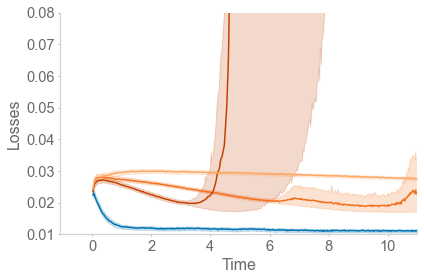

In [78]:
plt.figure(figsize=(6.4*1., 4.8*0.85))
cmap = cm.get_cmap('Oranges', 6)
start_cm_idx = 2
palette = [
    cmap(start_cm_idx+1),
    cmap(start_cm_idx+2),
    cmap(start_cm_idx),
    'C0'
    ]
sns.lineplot(
    x='Time', y='Losses', hue='Models', data=df,
    legend=None,
    palette=palette
    )
plt.ylim(0.01, 0.08)
plt.xlim(right=11)
plt.savefig('oja_rnn_loss.png', dpi=300)
plt.show()

In [120]:
def get_ff_peaks(X, state_inputs, num_states):
    ff_peaks = []
    for x in X:
        ff = []
        for _state in np.arange(num_states):
            idxs = state_inputs==_state
            if idxs.size == 0:
                ff.append(0)
                continue
            ff.append(np.mean(x[idxs]))
        argmax = np.argmax(ff)
        ff_peaks.append(argmax)
    return ff_peaks

oja_0.0005


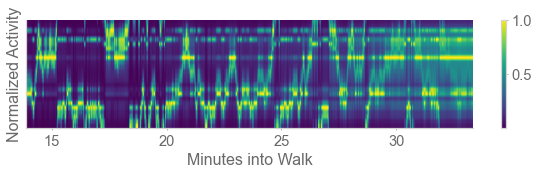

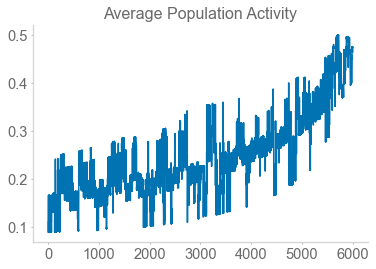

oja_0.001


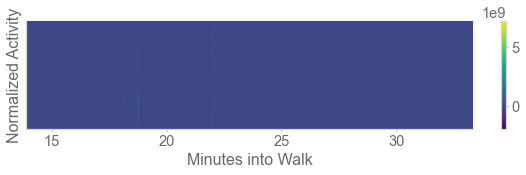

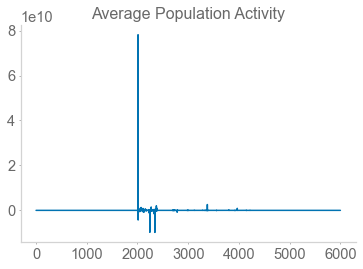

oja_0.0001


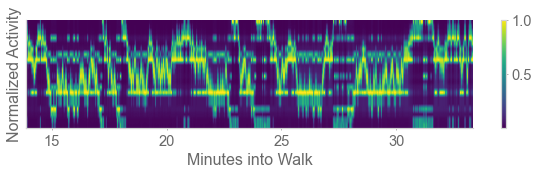

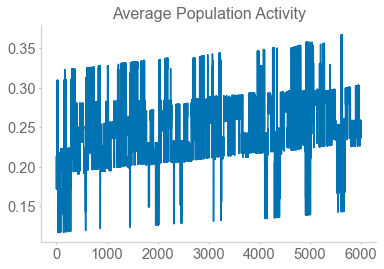

rnn


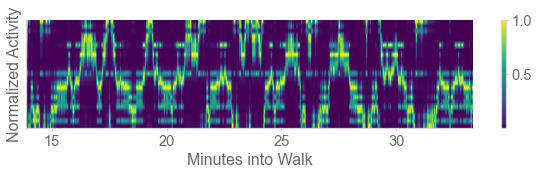

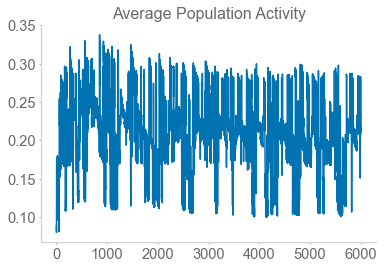

In [137]:
# Plot params
tick_mins = np.array([15, 20, 25, 30])
start_step = 2500
end_step = 6000

for model in os.listdir(exp_dir):
    model_dir = f'{exp_dir}{model}/'
    if not os.path.isdir(model_dir): continue
    if model == 'sr': continue
    print(model)
    results_p = f'{model_dir}output_example.p'
    with open(results_p, 'rb') as f:
        results = pickle.load(f)
    dset = results['dset']
    state_inputs = dset.state_inputs
    state_inputs = np.argmax(dset.state_inputs, axis=0)#[start_step:end_step]
    outputs = results['outputs'].T
    outputs = outputs[np.max(outputs, axis=1) > 1E-3]
    argsort = np.argsort(get_ff_peaks(outputs, state_inputs, dset.num_states))
    outputs = outputs[argsort,:]
    outputs = outputs/(np.max(outputs,axis=0)[np.newaxis,:])
    
    plt.figure(figsize=(10,2))
    plt.imshow(outputs[:,start_step:end_step], aspect="auto", cmap='viridis')
    plt.yticks([])
    plt.ylabel('Normalized Activity')
    plt.xticks((tick_mins*configs.dt_to_sec*60.)-start_step, tick_mins)
    plt.xlabel('Minutes into Walk')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.plot(np.mean(outputs, axis=0))
    plt.title('Average Population Activity')
    plt.show()